## Introduction

    This project aimed to accurately predict the winner of the WNBA’s Most Valuable Player (MVP) award using machine learning models and statistical analysis. The Most Valuable Player award is awarded every year to one WNBA player who is considered the 'most valuable' player in the league that season. I also wanted to see the difference in important factors to receiving the MVP award between the WNBA and NBA, and lastly identify trends among the award winners.
    
    


# Table of Contents
- [Introduction](#introduction)
- [Data Preprocessing](#data-preprocessing)
- [Model Training](#model-training)
- [Evaluation](#evaluation)

## 1.1 Notebook Preparation <a id='section_1_1'></a>

Necessary Library imports and warning filters are set here.

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

#from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet ###REMOVE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Global values that are used throughout the notebook.

In [121]:
# Defining the seasons and models used
seasons = ['2023-24','2022-23',
           '2021-22','2020-21','2019-20','2018-19','2017-18','2016-17','2015-16','2014-15','2013-14',
          '2012-13','2011-12','2010-11','2009-10','2008-09','2007-08','2006-07', '2005-06', #'2004-05', '2003-04'
]
           
models = ['SVM', 'XGBoost','Random Forest','AdaBoost','Gradient Boosting', 'LGBM']

path = current_path = os.getcwd()
# Path to local folder
path_data = '/Users/von/Desktop/Work/Projects/WNBA-MVP-Predictor'

test_number = 'Test 6'

sep = r'/'

Functions to return the previous or next season as a string.

In [122]:
def get_previous_season(current_season):
    years = current_season.split('-')
    
    first_year = str(int(years[0]) - 1)
    second_year = '{:02d}'.format(int(years[1]) - 1)
    return first_year + '-' + second_year

def get_next_season(current_season):
    years = current_season.split('-')
    
    first_year = str(int(years[0]) + 1)
    second_year = '{:02d}'.format(int(years[1]) + 1)
    return first_year + '-' + second_year

## 1.2 Data Preparation 
<a id='data-preprocessing'></a>

Getting all the data across seasons into a single dataframe for each stat type

In [123]:
def get_data(seasons):
    
    # Opening the data
    per_game = pd.DataFrame()
    totals = pd.DataFrame()
    advanced_stats = pd.DataFrame()
    standings = pd.DataFrame()


    total_games = 34
    seasons_games = {
        '2019-20': 22,
        '2020-21': 32,
        '2021-22': 36,
        '2022-23': 40,
        '2023-24': 40
    }

    for season in seasons:
        
        pergame = pd.read_csv(path_data+sep+'Data/Pergame-Stats'+sep+season+'-Pergame'+'.csv',
                               sep=',', decimal='.')
        
        total = pd.read_csv(path_data+sep+'Data/Total-Stats'+sep+season+'-Totals.csv',
                            sep=',', decimal='.')
        
        advanced = pd.read_csv(path_data+sep+'Data/Advanced-Stats'+sep+season+'-Advanced.csv',
                               sep=',', decimal='.')

        standing = pd.read_csv(path_data+sep+'Data/Standings'+sep+season+' Standings.csv',
                               sep=',', decimal='.')
        

        # First, make sure all Players' names are the same in every data file used
        pergame['Player'] = pergame['Player'].str.replace(r'\*.*', '', regex=True)
        advanced['Player'] = advanced['Player'].str.replace(r'\*.*', '', regex=True)
        total['Player'] = total['Player'].str.replace(r'\*.*', '', regex=True)


        # Drop duplicates based on Player, keeping the first occurrence ('TOT' prioritized)
        pergame = pergame.sort_values(by=['Player', 'Team'], key=lambda x: x == 'TOT', ascending=False)
        pergame = pergame.drop_duplicates(subset='Player', keep='first')
        advanced = advanced.sort_values(by=['Player', 'Team'], key=lambda x: x == 'TOT', ascending=False)
        advanced = advanced.drop_duplicates(subset='Player', keep='first')
        total = total.sort_values(by=['Player', 'Team'], key=lambda x: x == 'TOT', ascending=False)
        total = total.drop_duplicates(subset='Player', keep='first')

        
        # Change G and GS to G% and GS% because not all seasons had the same number of games played in them
        if season in seasons_games:
            total_games = seasons_games[season]
        
        pergame['G'] = pergame['G'] / total_games
        pergame['GS'] = pergame['GS'] / total_games
        
            
        pergame['Season'] = season
        total['Season'] = season
        advanced['Season'] = season
        standing['Season'] = season

        
        per_game = pd.concat([per_game,pergame], ignore_index=True)
        totals = pd.concat([totals,total], ignore_index=True)
        advanced_stats = pd.concat([advanced_stats,advanced], ignore_index=True)
        standings = pd.concat([standings,standing], ignore_index=True)
       
    
    per_game.rename(columns={'Team': 'Tm'}, inplace=True)
    totals.rename(columns={'Team': 'Tm'}, inplace=True)
    advanced_stats.rename(columns={'Team': 'Tm'}, inplace=True)

    return per_game, totals, advanced_stats, standings


Filtering out players that are unlikely to win the MVP award based on previous winner criteria

In [124]:
def treat_data(per_game, totals, advanced, standings, seasons):
    
    # Removing duplicate/empty columns
    per_game = per_game.drop(['Pos'], axis=1)
    totals = totals.drop(['G','GS', 'PF', 'Pos', 'FG%', '2P%', '3P%', 'FT%'], axis=1)
    advanced = advanced.drop(['G','MP', 'Unnamed: 21', 'G.1', 'MP.1'], axis=1)
    
    cols = ['Player','Season','Team','Age','Tm','G','GS', 'Pos']
    
    # Identifying the variables
    for col in per_game.columns:
        if col not in cols:
            new_col = col+'_PERGAME'
            per_game = per_game.rename(columns={col:new_col})
    for col in totals.columns:
        if col not in cols:
            new_col = col+'_TOTAL'
            totals = totals.rename(columns={col:new_col})
    for col in advanced.columns:
        if col not in cols:
            new_col = col+'_ADVANCED'
            advanced = advanced.rename(columns={col:new_col})
    
    # Merging the bases
    data = per_game.merge(advanced, on=['Player','Season','Tm'], how='left', validate='1:1')
    
    data = data.merge(totals, on=['Player','Season','Tm'], how='left', validate='1:1')
    
    dict_teams = {'Connecticut Sun': 'CON', 'Indiana Fever': 'IND',
                  'Las Vegas Aces': 'LVA', 'Chicago Sky': 'CHI',
                  'Minnesota Lynx': 'MIN', 'Seattle Storm': 'SEA',
                  'Dallas Wings': 'DAL', 'New York Liberty': 'NYL',
                  'Washington Mystics': 'WAS', 'Los Angeles Sparks': 'LAS',
                  'Atlanta Dream': 'ATL', 'San Antonio Stars': 'SAS',
                  'Tulsa Shock': 'TUL', 'Phoenix Mercury': 'PHO',
                  'Sacramento Monarchs': 'SAC', 'Houston Comets': 'HOU',
                  'Detroit Shock': 'DET', 'Charlotte Sting': 'CHA'
    }
    
    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team',0:'Tm'})
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')
    standings = standings.rename(columns={'Rk':'Seed'})
    wins = (standings['Overall'].str.split('-',expand=True)[0]).astype(int)
    games = ((standings['Overall'].str.split('-',expand=True)[0]).astype(int)+(standings['Overall'].str.split('-',expand=True)[1]).astype(int))
    standings['PCT'] = wins/games
    
    data = data.merge(standings, on=['Tm','Season'], how='left', validate='m:1')
    
    data['Player'] = data['Player'].str.replace('*','')

    mvps = pd.read_csv(path_data+sep+'Data'+sep+'MVPs.csv',sep=',', decimal='.')

    data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0) 

    data['Player'] = data['Player'].str.split('\\', expand=True)[0]
    
    # Removing duplicate lines from traded players, removing players from seasons that have already won the award
    dataf = pd.DataFrame()
    
    for season in seasons:
        data_season = data[data['Season']==season]
        data_season = data_season.drop_duplicates(subset=['Player'], keep='first')

        dataf = pd.concat([dataf,data_season], ignore_index=True)

    
    # Filtering the data (MVP)
    dataf = dataf[((dataf['G']>0.75)&(dataf['PTS_PERGAME']>=12.0)
                   &(dataf['FGA_PERGAME']>=9.9)&(dataf['MPG_PERGAME']>=28.7)&(dataf['PER_ADVANCED']>=17.8)
                   &(dataf['TRB_PERGAME']>=2.5)&(dataf['AST_PERGAME']>=0.6)&(dataf['FG%_PERGAME']>0.38)
                   &(dataf['PER_ADVANCED']<=27.7)) | ((dataf['MVP Share']>0))].reset_index(drop=True)
    
    # Baseline for the criteria:
    # 14.0 pts Lindsay Whalen in 2007-08
    # 20G, by Breanna Stewart in 2019-20
    # 9.9FGA, by Lindsay Whalen in 2007-08
    # MPG is 28.7, by Candace Parker in 2012-13
    # FG% is 0.383, by Tamika Catchings in 2004-05
    # TRB is 2.5, by Sue Bird in 2007-08 
    # Lowest AST is 0.6, by Sylvia Fowles in 2010-11
    # PER is 17.8, by Sue Bird in 2007-08
        
    dataf = dataf.drop(['Tm_x','Tm_y',
                         'Code Name', 'Overall', 'Pts Won', 'Pts Max', 'First', 'Pos',
    ],  axis=1)
    #print(dataf.columns)
    dataf.to_csv(f'{test_number}/FinalDataFrame-{test_number}.csv', index=False)
    dataf = dataf.drop(['Team', 'Age'], axis=1)
    
    return dataf

In [125]:
pd.options.display.max_seq_items = 203

per_game, totals, advanced, standings = get_data(seasons)

In [126]:
data = treat_data(per_game, totals, advanced, standings, seasons)

In [127]:
pd.options.display.max_rows = 532
#data[data["MVP Rank"].isin(["1", "2", "2T"])][["MVP Rank","Player","Season", "Seed", "PTS_diff", "PTS_diff_BS", 'USG%_ADVANCED',]]

Final list of columns to be used as training/testing data

In [128]:
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 4000
data.columns

Index(['Player', 'G', 'GS', 'MPG_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'FT_PERGAME', 'FTA_PERGAME',
       'FT%_PERGAME', 'ORB_PERGAME', 'TRB_PERGAME', 'AST_PERGAME',
       'STL_PERGAME', 'BLK_PERGAME', 'TOV_PERGAME', 'PF_PERGAME',
       'PTS_PERGAME', 'Season', 'PER_ADVANCED', 'TS%_ADVANCED',
       'eFG%_ADVANCED', '3PAr_ADVANCED', 'FTr_ADVANCED', 'ORB%_ADVANCED',
       'TRB%_ADVANCED', 'AST%_ADVANCED', 'STL%_ADVANCED', 'BLK%_ADVANCED',
       'TOV%_ADVANCED', 'USG%_ADVANCED', 'ORtg_ADVANCED', 'DRtg_ADVANCED',
       'OWS_ADVANCED', 'DWS_ADVANCED', 'WS_ADVANCED', 'WS/40_ADVANCED',
       'MP_TOTAL', 'FG_TOTAL', 'FGA_TOTAL', '3P_TOTAL', '3PA_TOTAL',
       '2P_TOTAL', '2PA_TOTAL', 'FT_TOTAL', 'FTA_TOTAL', 'ORB_TOTAL',
       'TRB_TOTAL', 'AST_TOTAL', 'STL_TOTAL', 'BLK_TOTAL', 'TOV_TOTAL',
       'PTS_TOTAL', 'Seed', 'PCT', 'MVP Rank', 'MVP Share'],
      dtype='obje

Final number of players per season to be trained upon.  NBA MVP model had 20-29 candidates to train upon per season in comparison

In [129]:
data['Season'].value_counts()

2007-08    29
2005-06    20
2017-18    20
2016-17    20
2011-12    19
2012-13    19
2023-24    19
2008-09    18
2021-22    18
2022-23    17
2010-11    17
2006-07    17
2018-19    15
2013-14    15
2009-10    15
2015-16    13
2020-21    13
2014-15    13
2019-20    12
Name: Season, dtype: int64

In [130]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, model, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Model': [model],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics

## 2. Training Models <a id='chapter2'></a>

In [131]:
def func_models(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    
    # Create the Is_Last_Year_MVP column
    data['Is_Last_Year_MVP'] = 0  # Initialize with 0

    mvp_winners = data[(data['MVP Rank'] == '1') | (data['MVP Rank'] == 1)] 
    # Create a new column for the 'Season' after the MVP win using the get_next_season function
    mvp_winners['Next_Season'] = mvp_winners['Season'].apply(get_next_season)

    # Merge back into the main 'data' dataframe to mark players who were MVP last year
    data = data.merge(mvp_winners[['Player', 'Next_Season']], 
                    left_on=['Player', 'Season'], 
                    right_on=['Player', 'Next_Season'], 
                    how='left', 
                    indicator=True)

    # Set 'Is_Last_Year_MVP' to 1 where there was a match (player was MVP the previous year)
    data.loc[data['_merge'] == 'both', 'Is_Last_Year_MVP'] = 1

    # Drop the extra columns used for merging
    data.drop(columns=['Next_Season', '_merge'], inplace=True)
    #data = data[data['Player'] == '']

    for season in seasons:

        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]

        final_drops = [
            'Is_Last_Year_MVP'
        ]

        # Test 2
        X_train = data_train.drop(['MVP Share','MVP Rank','Player','Season',] + final_drops, axis=1)
        y_train = data_train['MVP Share']

        X_test = data_test.drop(['MVP Share','MVP Rank','Player','Season',]+ final_drops, axis=1)
        y_test = data_test['MVP Share']

        initial_results = data_test[['Player','Season','MVP Share','MVP Rank']]
        results = initial_results.copy()
        #print(len(X_train.columns))

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            # Creating instance for each model
            if model=='SVM':
                param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                             'kernel': ['linear','rbf','poly'],
                             'gamma': ['scale','auto'],
                             'degree': [2,3,4],
                             'epsilon': [0.1,0.5,1]}
                svr_model = SVR()
                grid = GridSearchCV(svr_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = SVR(**grid.best_params_)
                best_params.append(grid.best_params_)

            elif model=='Elastic Net':
                param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                              'l1_ratio':[0.01,0.1,0.5,0.7,0.95,0.99,1]}
                elastic_net_model = ElasticNet()
                grid = GridSearchCV(elastic_net_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                final_model = ElasticNet(**grid.best_params_)
                best_params.append(grid.best_params_)
            elif model=='XGBoost':
                param_grid = {'n_estimators': [100, 200],
                              'learning_rate': [0.01, 0.1],
                              'max_depth': [3, 5, 7],
                              'subsample': [0.7, 1.0]}
                xg_boost = XGBRegressor()
                grid = GridSearchCV(xg_boost, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                final_model = XGBRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Random Forest':
                param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True]}
                rfc = RandomForestRegressor()
                grid = GridSearchCV(rfc, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = RandomForestRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='AdaBoost':
                param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
                ada_model = AdaBoostRegressor()
                grid = GridSearchCV(ada_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = AdaBoostRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Gradient Boosting':
                param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
                gb_model = GradientBoostingRegressor()
                grid = GridSearchCV(gb_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = GradientBoostingRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='LGBM':
                param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                              'num_leaves':[5,10,20,30],
                              'min_child_samples': [10, 25, 50],
                              'max_depth':[2,3,4],
                              'colsample_bytree':[0.6,0.7,0.8,0.9],
                              'min_split_gain':[0,0.01,0.1,0.2],
                              'verbosity':[-1]}
                lgbm_model = LGBMRegressor()
                grid = GridSearchCV(lgbm_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = LGBMRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            final_model.fit(scaled_X_train, y_train)
            
            
            print("FM:")
            print(final_model)
            print("SEP: ")
            print(sep)
            print("MODEL: ")
            print(model)
            
            pickle.dump(final_model,open(path_data+sep+'Models'+sep+model+'.dat','wb'))
            
            
            y_pred = final_model.predict(scaled_X_test)
        
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            temp_df = initial_results.copy()
            temp_df['Predicted MVP Share '+model] = pd.Series(y_pred).values
            #print(temp_df)
            
            # Select the 'Player', 'Season' from data where 'Is_Last_Year_MVP' is 1
            mvp_last_year = data[data['Is_Last_Year_MVP'] == 1][['Player', 'Season']]
            # Merge temp_df with the filtered MVP data to find rows where Player and Season match
            temp_df = temp_df.merge(mvp_last_year, on=['Player', 'Season'], how='left', indicator=True)
            # Multiply 'Predicted MVP Share' by 0.8 for rows that have a match ('both' in the merge indicator)
            temp_df.loc[temp_df['_merge'] == 'both', 'Predicted MVP Share '+model] *= 0.8
            # Drop the '_merge' column after the operation if it's no longer needed
            temp_df.drop(columns=['_merge'], inplace=True)
            
            results_sorted = temp_df.sort_values(by='Predicted MVP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Share','MVP Rank'])
            
            #Added to account for 
            #results['MVP_Share_Adjusted'] = results['MVP Share']
            #results.loc['Is_Last_Year_MVP', 'MVP_Share_Adjusted'] *= 0.75


        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
    
    np.savetxt(path_data+sep+r'Models\params.csv', best_params, delimiter =', ', fmt ='% s')
    
    return final_results, metrics, best_params

In [132]:
def average_metrics(metrics):
    # Averages of each of the models
    final_metrics = pd.DataFrame()
    for model in metrics['Model'].unique():
        metric = metrics[metrics['Model']==model]
        rmse = round(metric['RMSE'].mean(),3)
        r2 = round(metric['R²'].mean(),3)

        dict_met = {'Model': [model],
                    'RMSE': [rmse],
                    'R²': [r2]}

        data_frame = pd.DataFrame(data=dict_met)
        final_metrics = pd.concat([final_metrics,data_frame], ignore_index=True)

    return final_metrics

## 2.1 One Season Performance <a id='section_2_1'></a>

Results from the most recent WNBA season

In [119]:
pd.options.display.max_rows = 50

final_results, metrics, best_params = func_models(data, seasons, models, 1)
final_metrics = average_metrics(metrics)
final_metrics.to_csv(f'/Users/von/Desktop/Work/Projects/WNBA-MVP-Predictor/{test_number}/One Season/2003-04-Results.csv', index=False)
final_metrics

FM:
SVR(C=0.5, degree=2, gamma='auto')
SEP: 
/
MODEL: 
SVM
FM:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
SEP: 
/
MODEL: 
XGBoost
FM:
RandomForestRegressor(max_features=5, n_estimators=150, oob_score=True)
SEP: 
/
MODEL: 
Random Forest
FM:
AdaBoostRegressor(learning_rate=0.05, n_estimators=100)
SEP: 

,Model,RMSE,R²
0,SVM,0.185,0.528
1,XGBoost,0.122,0.794
2,Random Forest,0.146,0.708
3,AdaBoost,0.113,0.825
4,Gradient Boosting,0.114,0.820
5,LGBM,0.117,0.810


In [133]:
def create_rank(final_results, n_rank):
    rank_final = pd.DataFrame()

    scores = {
        'MVP Rank SVM': 0,
        'MVP Rank XGBoost': 0,
        'MVP Rank Random Forest': 0,
        'MVP Rank AdaBoost': 0,
        'MVP Rank Gradient Boosting': 0,
        'MVP Rank LGBM': 0


    }
    for season in final_results['Season'].unique():
        temp = final_results[final_results['Season']==season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='MVP Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MVP Rank Real'] = rank_real['Player']
        rank['MVP Share Real'] = rank_real['MVP Share']
        for model in models:
            try:
                temp2 = temp.sort_values(by='Predicted MVP Share '+model, ascending=False)[:n_rank].reset_index(drop=True)
                rank['MVP Rank '+model] = temp2['Player']
                rank['MVP Share '+model] = round(temp2['Predicted MVP Share '+model],3)

            except:
                continue

        rank['Season'] = season   
        rank_final = pd.concat([rank_final, rank], ignore_index=True)

    
    for i, row in rank_final.iterrows():
        for model in models:
            if row['MVP Rank Real'] == row['MVP Rank '+model]:
                scores['MVP Rank '+model] += 1
    
    return rank_final, scores

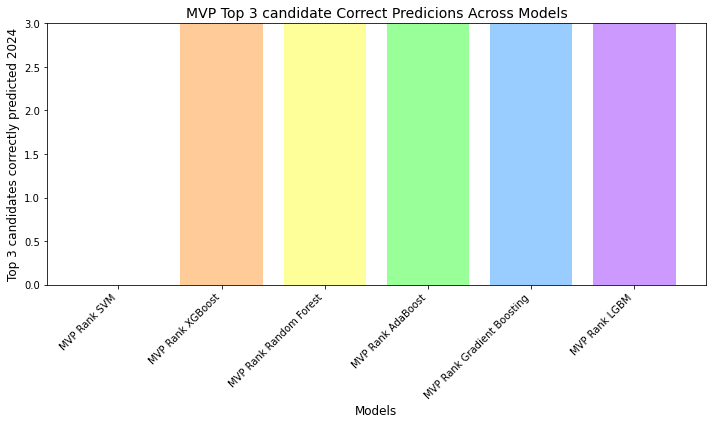

In [145]:
rank_final, scores = create_rank(final_results, 3)
rank_final.to_csv(f'/Users/von/Desktop/Work/Projects/WNBA-MVP-Predictor/{test_number}/One Season/2023-24-Ranks.csv', index=False)

#Don't include LGBM if it wasn't used
if scores['MVP Rank LGBM'] == 0:
    scores.pop('MVP Rank LGBM')

# Creating the bar graph
model_names = list(scores.keys())
values = list(scores.values())

colors = ['#FF9999', '#FFCC99', '#FFFF99', '#99FF99', '#99CCFF', '#CC99FF']
plt.figure(figsize=(10, 6))
plt.bar(model_names, values, color=colors)

# Setting the labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Top 3 candidates correctly predicted 2024', fontsize=12)
plt.title('MVP Top 3 candidate Correct Predicions Across Models', fontsize=14)

# Adjust y-axis to max value 18
plt.ylim(0, 3)

# Display the plot
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
plt.tight_layout()
plt.show()

Five out of the six models used guessed the top three candidates correctly for the 2023-24 WNBA season.  The SVM model actually did get the top three correct, but got the order wrong as you can see below.

In [135]:
rank_final

,MVP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,MVP Rank XGBoost,MVP Share XGBoost,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,MVP Rank LGBM,MVP Share LGBM,Season
0,A'ja Wilson,1.000,Napheesa Collier,0.726,A'ja Wilson,0.783,A'ja Wilson,0.711,A'ja Wilson,0.781,A'ja Wilson,0.777,A'ja Wilson,0.887,2023-24
1,Napheesa Collier,0.697,Breanna Stewart,0.634,Napheesa Collier,0.776,Napheesa Collier,0.631,Napheesa Collier,0.691,Napheesa Collier,0.713,Napheesa Collier,0.781,2023-24
2,Breanna Stewart,0.440,A'ja Wilson,0.423,Breanna Stewart,0.624,Breanna Stewart,0.570,Breanna Stewart,0.607,Breanna Stewart,0.561,Breanna Stewart,0.630,2023-24


##  Old Seasons

In [136]:
def old_seasons(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    # Create the Is_Last_Year_MVP column
    data['Is_Last_Year_MVP'] = 0  # Initialize with 0

    mvp_winners = data[(data['MVP Rank'] == '1') | (data['MVP Rank'] == 1)] 
    # Create a new column for the 'Season' after the MVP win using the get_next_season function
    mvp_winners['Next_Season'] = mvp_winners['Season'].apply(get_next_season)

    # Merge back into the main 'data' dataframe to mark players who were MVP last year
    data = data.merge(mvp_winners[['Player', 'Next_Season']], 
                    left_on=['Player', 'Season'], 
                    right_on=['Player', 'Next_Season'], 
                    how='left', 
                    indicator=True)

    # Set 'Is_Last_Year_MVP' to 1 where there was a match (player was MVP the previous year)
    data.loc[data['_merge'] == 'both', 'Is_Last_Year_MVP'] = 1

    # Drop the extra columns used for merging
    data.drop(columns=['Next_Season', '_merge'], inplace=True)
    # Need to manually add this as we have no data from 2002-03
    data.loc[(data['Player'] == 'Lauren Jackson') & (data['Season'] == '2003-04'), 'Is_Last_Year_MVP'] = 1

    
    for season in seasons:
            
        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]


        #TESTING FOR NOW
        ###
        ####
        final_drops = ['Is_Last_Year_MVP']

        X_train = data_train.drop(['MVP Share','MVP Rank','Player','Season',]+final_drops, axis=1)
        y_train = data_train['MVP Share']

        X_test = data_test.drop(['MVP Share','MVP Rank','Player','Season']+final_drops, axis=1)
        y_test = data_test['MVP Share']

        initial_results = data_test[['Player','Season','MVP Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            
            if model=='Elastic Net':
                continue
            
            # Opening the models already created          
            current_model = pickle.load(open(path_data+sep+'Models'+sep+model+'.dat', 'rb'))
                
            current_model.fit(scaled_X_train, y_train)
            y_pred = current_model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            temp = initial_results.copy()
            temp['Predicted MVP Share '+model] = pd.Series(y_pred).values

             # Select the 'Player', 'Season' from data where 'Is_Last_Year_MVP' is 1
            mvp_last_year = data[data['Is_Last_Year_MVP'] == 1][['Player', 'Season']]
            # Merge temp_df with the filtered MVP data to find rows where Player and Season match
            temp = temp.merge(mvp_last_year, on=['Player', 'Season'], how='left', indicator=True)
            # Multiply 'Predicted MVP Share' by 0.8 for rows that have a match ('both' in the merge indicator)
            temp.loc[temp['_merge'] == 'both', 'Predicted MVP Share '+model] *= 0.8
            # Drop the '_merge' column after the operation if it's no longer needed
            temp.drop(columns=['_merge'], inplace=True)

            results_sorted = temp.sort_values(by='Predicted MVP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
        
    return final_results, metrics

## 2.2 Multiple Seasons Performance <a id='section_2_2'></a>

Results from the past 19 seasons.

In [137]:
pd.options.display.max_rows = 50
pd.options.display.max_seq_items = 100
final_results_seasons, metrics = old_seasons(data, seasons, models, 19)
final_metricas = average_metrics(metrics)
final_metricas.to_csv(f'/Users/von/Desktop/Work/Projects/WNBA-MVP-Predictor/{test_number}/Multiple Seasons/2006-24-Results.csv', index=False)
final_metricas


,Model,RMSE,R²
0,SVM,0.156,0.619
1,XGBoost,0.151,0.620
2,Random Forest,0.160,0.592
3,AdaBoost,0.159,0.579
4,Gradient Boosting,0.158,0.585
5,LGBM,0.151,0.634


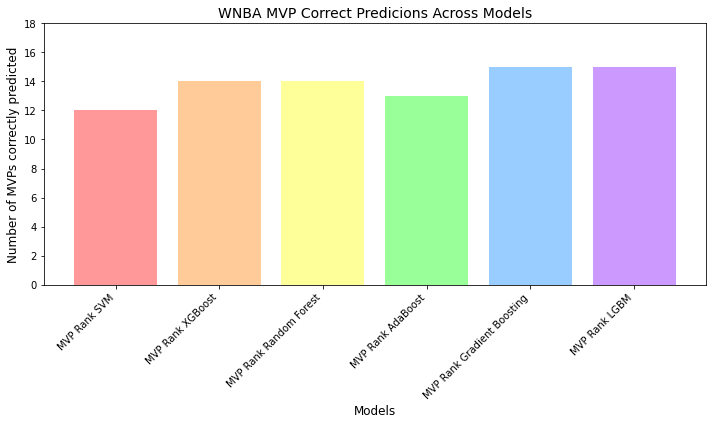

In [138]:
pd.options.display.max_rows = 400

rank_final_2, scores = create_rank(final_results_seasons, 1)
rank_final_2.to_csv(f'/Users/von/Desktop/Work/Projects/WNBA-MVP-Predictor/{test_number}/Multiple Seasons/2006-24-Ranks.csv', index=False)

#Don't include LGBM if it wasn't used
if scores['MVP Rank LGBM'] == 0:
    scores.pop('MVP Rank LGBM')

# Creating the bar graph
model_names = list(scores.keys())
values = list(scores.values())

colors = ['#FF9999', '#FFCC99', '#FFFF99', '#99FF99', '#99CCFF', '#CC99FF']
plt.figure(figsize=(10, 6))
plt.bar(model_names, values, color=colors)

# Setting the labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Number of MVPs correctly predicted', fontsize=12)
plt.title('WNBA MVP Correct Predicions Across Models', fontsize=14)

# Adjust y-axis to max value 18
plt.ylim(0, 18)

# Display the plot
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
plt.tight_layout()
plt.show()

The LGBM and Gradient Boosting models predicted the highest number of seasons correctly at 15.  The rest predicted correctly in at least 12 out of the psat 19 seasons

In [139]:
rank_final_2

,MVP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,MVP Rank XGBoost,MVP Share XGBoost,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,MVP Rank LGBM,MVP Share LGBM,Season
0,A'ja Wilson,1.000,Napheesa Collier,0.726,A'ja Wilson,0.783,A'ja Wilson,0.725,A'ja Wilson,0.802,A'ja Wilson,0.777,A'ja Wilson,0.887,2023-24
1,Breanna Stewart,0.743,Breanna Stewart,0.726,Breanna Stewart,0.940,Breanna Stewart,0.755,Breanna Stewart,0.797,Breanna Stewart,0.875,Breanna Stewart,0.949,2022-23
2,A'ja Wilson,0.854,A'ja Wilson,0.590,A'ja Wilson,0.748,A'ja Wilson,0.636,A'ja Wilson,0.723,A'ja Wilson,0.644,A'ja Wilson,0.659,2021-22
3,Jonquel Jones,0.994,Jonquel Jones,0.580,Brittney Griner,0.580,Brittney Griner,0.487,Brittney Griner,0.607,Jonquel Jones,0.596,Jonquel Jones,0.718,2020-21
4,A'ja Wilson,0.974,Breanna Stewart,0.281,A'ja Wilson,0.300,A'ja Wilson,0.310,A'ja Wilson,0.234,A'ja Wilson,0.244,A'ja Wilson,0.244,2019-20
5,Elena Delle Donne,0.977,Elena Delle Donne,0.572,Elena Delle Donne,0.534,Elena Delle Donne,0.516,Elena Delle Donne,0.670,Elena Delle Donne,0.639,Elena Delle Donne,0.700,2018-19
6,Breanna Stewart,0.954,Breanna Stewart,0.882,Breanna Stewart,0.793,Breanna Stewart,0.662,Breanna Stewart,0.781,Breanna Stewart,0.775,Breanna Stewart,0.697,2017-18
7,Sylvia Fowles,0.962,Nneka Ogwumike,0.489,Sylvia Fowles,0.686,Sylvia Fowles,0.611,Sylvia Fowles,0.807,Sylvia Fowles,0.754,Sylvia Fowles,0.932,2016-17
8,Nneka Ogwumike,0.928,Maya Moore,0.552,Nneka Ogwumike,0.804,Nneka Ogwumike,0.651,Nneka Ogwumike,0.755,Nneka Ogwumike,0.681,Nneka Ogwumike,0.642,2015-16
9,Elena Delle Donne,0.987,Elena Delle Donne,0.788,Elena Delle Donne,0.945,Elena Delle Donne,0.695,Elena Delle Donne,0.782,Elena Delle Donne,0.854,Elena Delle Donne,0.881,2014-15


As shown in this chart the accuracy is very high for most models on the past 12 seasons. The LGBM model predicts the winner of the past 12 seasons at 100% accuracy, with most wrong predictions coming from 2007-2012

In [140]:
data_test = data[data['Season']=='2023-24']
data_train = data[data['Season']!='2023-24']

final_drops = ['Is_Last_Year_MVP']

X_test = data_test.drop(['MVP Share','MVP Rank','Player','Season',] + final_drops, axis=1) 
X_train = data_train.drop(['MVP Share','MVP Rank','Player','Season' ,] + final_drops, axis=1)

scaler = StandardScaler()
scaler.fit(X_train)
feature_names = X_test.columns
print(feature_names)

scaled_X_test = scaler.transform(X_test)
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=feature_names)
#scaled_X_test_df

Index(['G', 'GS', 'MPG_PERGAME', 'FG_PERGAME', 'FGA_PERGAME', 'FG%_PERGAME',
       '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME', '2PA_PERGAME',
       '2P%_PERGAME', 'FT_PERGAME', 'FTA_PERGAME', 'FT%_PERGAME',
       'ORB_PERGAME', 'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME',
       'BLK_PERGAME', 'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME',
       'PER_ADVANCED', 'TS%_ADVANCED', 'eFG%_ADVANCED', '3PAr_ADVANCED',
       'FTr_ADVANCED', 'ORB%_ADVANCED', 'TRB%_ADVANCED', 'AST%_ADVANCED',
       'STL%_ADVANCED', 'BLK%_ADVANCED', 'TOV%_ADVANCED', 'USG%_ADVANCED',
       'ORtg_ADVANCED', 'DRtg_ADVANCED', 'OWS_ADVANCED', 'DWS_ADVANCED',
       'WS_ADVANCED', 'WS/40_ADVANCED', 'MP_TOTAL', 'FG_TOTAL', 'FGA_TOTAL',
       '3P_TOTAL', '3PA_TOTAL', '2P_TOTAL', '2PA_TOTAL', 'FT_TOTAL',
       'FTA_TOTAL', 'ORB_TOTAL', 'TRB_TOTAL', 'AST_TOTAL', 'STL_TOTAL',
       'BLK_TOTAL', 'TOV_TOTAL', 'PTS_TOTAL', 'Seed', 'PCT'],
      dtype='object')


In [141]:
svm_model = pickle.load(open(path_data+sep+'Models'+sep+'LGBM.dat','rb'))


In [142]:
# Define a prediction function
def predict_fn(X):
    return svm_model.predict(X)

# Use SHAP's KernelExplainer
explainer = shap.KernelExplainer(predict_fn, shap.sample(scaled_X_test_df, 100))
shap_values = explainer.shap_values(scaled_X_test_df)

#explainer = shap.Explainer(svm_model.predict, scaled_X_test)
#shap_values = explainer(scaled_X_test)

  0%|          | 0/19 [00:00<?, ?it/s]

## 2.2.1 Important Variables <a id='sub_section_2_2_1'></a>

Shap value summary plots to shoe how much each feature swayed changed the prediction.

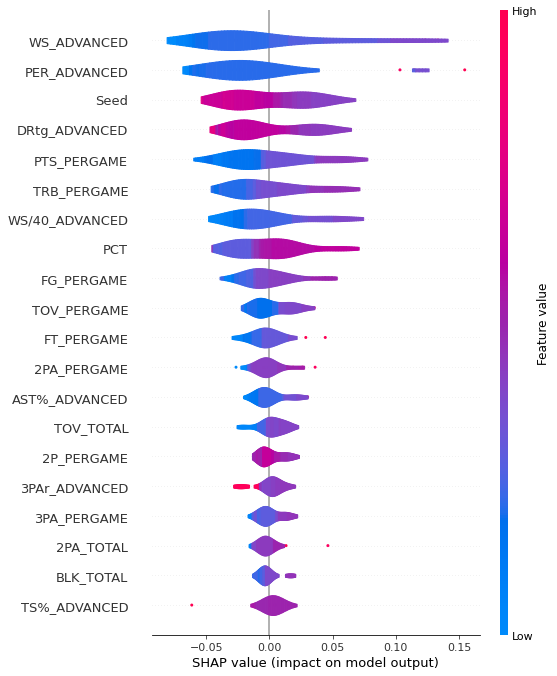

In [143]:
shap.summary_plot(shap_values, scaled_X_test_df,plot_type='violin') #X_test, plot_type='violin') # Top 20 variables

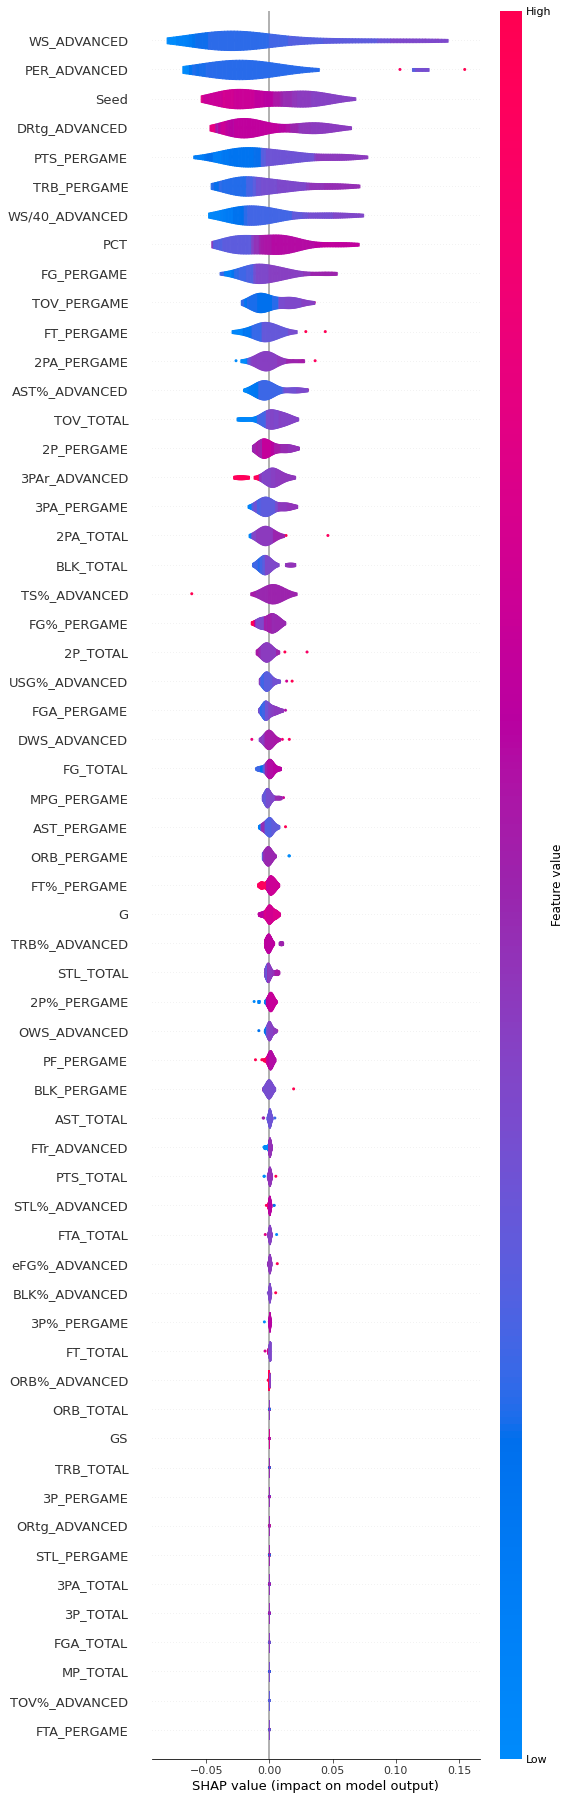

In [144]:
shap.summary_plot(shap_values, X_test, plot_type='violin', max_display=len(X_test.columns)) # All features

## 3. Conclusion <a id='chapter3'></a>

    The results from Test 6 were very well. The LGBM model predicted the MVP winner for 15 out of the last 19 seasons correctly, while being correct 12 out of the last 12 seasons from 2013-2024.

    Interestingly, I noticed the LGBM model only predicted incorrectly from 2008-2012, where it went 4/5 on predictions in those years.  
        - In 2008, when Candace Parker won, 25% of the votes came from fans, possibly accounting for the misprediction by the models. She was on the LA Sparks at the time which probably played a huge part in the voting, as Los Angeles teams in general usually have large and hardcore fanbases.

        - For 2009, most of the models predicted Lauren Jackson when the winner was actually Diana Taurasi. This could partially be due to the fact that the percentage of games started in the season is seen as the 30th most important variable to determining the MVP winner by the LGBM model, making it not have a huge impact. This means Lauren Jackson was most likely not docked enough for only having played in 26/34 games that year, compared to at least 31/34 games played by the top 5 candidates. Unfortunately, most of the games she missed happened to be at the end of the season, making it difficult for her to be considered for the award.
        
        - The 2011 MVP winner was Tamika Catchings, yet the models predicted either Tina Charles or Sylvia Fowles, the 2nd and 3rd place winners of the award that year, respectively.  Looking into the matter, I believe this can be attributed to a couple extraordinary factors not accounted for by the model. In the 2011 season she became the WNBA all time steals leader, after averaging a whopping 2.9 SPG in 4 prior seasons. She also led her own team in PPG, RPG, APG, and APG for the second straight year, while leading the Indiana Fever to 1st seed in the East, making her very deserving of the award even though by the numbers, Sylvia Fowles had a better year comparitively in most categories.


    The main thing that stood out from the results of the NBA MVP award prediction model was that I had to add a negative weight for the WNBA players that had won MVP in the prior year, where on the other hand the NBA model didn't have to be altered to specifically account for that.  This makes sense because since the inception of the WNBA, there has only been one player to ever win back to back mvps, being Cynthia Cooper in 1997 and 1998, the first two years of the WNBA.  Since then, nobody has acheived the same feat.  On the contrast, NBA back to back MVP winners has happened 7 times since 2001, by 6 different players, making it much more likely for someone to win the award back to back in the NBA.  Nobody has won the award for the 3rd time in a row since Larry Bird in 1986.

    There were some similarites in the top 10 most impactful feature variables for the NBA and WNBA models.  Seed, (WS/40,WS/48), PER, FGM pergame, and Team win percent all made the top 10 in both models. PER could be determined as the single most impactful factor in determining either league's MVP as it makes top 2 in each model.  
    
    Out of the rest of the top 10, perhaps the most interesting is the advanced stat Defensive Rating. It is the 4th most impactful feature variable for WNBA MVP, yet not in the way one might think.  It was discovered that the HIGHER the rating was, the LOWER the chance is of becoming MVP.  My first thought is simply that those with the highest Defensive rating are usually not the highest producers on offense, which is the primary criteria voters look at first.  However, that doesn't mean MVP candidates have low Defensive Rating, instead it looks like most winners have an average Defensive Rating.

    Another interesting discovery is that out of the big 3, (Pts, Reb, Ast) assists have the least impact on MVP winner by far.  AST% was the 48th greatest influence for NBA MVP and 13th greatest for WNBA MVP.  With an average of just under 7.5 APG over the last 10 seasons, this is 31% less than the league's leading APG value (10.8 average over last 10 seasons). The PPG average was 28.6 PPG among the past 10 NBA MVP winners, which was only 11% lower than the average of the highest scoring player in each of those seasons at 31.8 PPG.  

    Seeing rebounds being highly favored over assists in the WNBA model supports the claim that the W is a league dominated by "bigs". There's only been one Guard (Diana Taurasi) to win MVP in the past 16 seasons.  Comparatively, the NBA has awarded a Guard with MVP honors 5 times in the past 16 seasons.  My belief as to why it's harder for Guards to win MVP in the WNBA is because they don't average a substantially larger amount of points per game than the best Forwards and Centers in the league.  Diana Taurasi, the last Guard to win the award, averaged 5.3 PPG more than the runner-up Tamika Catchings. I think it will continue to take differences in PPG similar to this for Guards to win over their Forward/Center counterparts.  Before Taurasi, it was Sheryl Swoopes in 2005, transforming the Houston Comets into a playoff team and averaging 1.0 PPG more than 2nd place winner Lauren Jackson.  Despite winning the award, she actually had LESS 1st place votes than Jackson and won in the closest MVP race in WNBA history, due to a higher amount of 2nd place votes. This further supports just how hard it is for a Guard to acheive MVP status in the WNBA.  

    To demonstrate that Guards also have to go above and beyond in the NBA to win the MVP award, I will briefly break down the last 3 winners. James Harden won in 2018, averaging a league high 30.4 PPG (2.9 PPG greater than 2nd place winner LeBron James).  Perhaps most notable about his season is that he led the Houston Rockets to 1st in the West winning an astonishing 65 games, making it one of the top 20 regular seasons performances in NBA history.  Before Harden, there was 2017 Russell Westbrook, winning the award averaging 31.6 PPG (6.1 PPG higher than the next non-guard runner-up Kawhi Leonard). His phenomenal season averaging a triple-double makes him deserving of the award without a doubt, yet further exemplifies the harsh criteria needed to be met by a guard to be crowned Most Valuable Player.  Moving on to 2016 Stephen Curry, the first ever unanimous MVP, Steph averaged 30.1 PPG, (8.9 PPG higher than the 2nd place candidate) anchoring the Warriors to the absolute best regular season in NBA history with a 73-9 record, making this a generational season performance by a guard.

    Now that we know just how hard it is for Guards to win MVP, I will discuss my thoughts as to why.  Given that the Forwards and Centers of the WNBA/NBA are naturally bigger in size than Guards, they are usually more athletically capable of doing more things on the court.  Their difference in height, weight, and wingspan make it easier for them to get deflections, blocks, haul in rebounds, and even get better shot contests, usually leading to them having better defensive per-game and advanced stats, along with offensive and defensive rebounds.  The disparity in RPG between even the top rebounding Guards and the rest ofthe league is glaring.  The highest RPG for the 2024 season belonged to Angel Reese with 13.1 RPG, (5.1 ORPG) and the closest to that mark was Caitlin Clark, averaging 5.7 RPG – a huge difference!  Meanwhile, the highest APG count was recorded by Caitlyn Clark, who finished the season with 8.4 APG.  Not too far behind her was Alyssa Thomas, Forward of the Connecticut Sun who averaged 7.9 APG, only 0.5 APG behind Clark. Although only a single example, it shows at a basic level that Forwards are much closer to doing what Guards excell at than Guards are to doing the jobs of Forwards.  This explains a bit why Guards have to do their job exceptionally well to take home the Most Valuable Player award.  I believe the best way for guards to take home the MVP trophy is to average much more points per game than the rest of the competition while leading their team to a great season.


